## **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5, 2)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.unicode_minus'] = False

### **Define some functions**

In [2]:
def extract_raw_data(fn_dict, fn_type):
    df = pd.read_csv(fn_dict[fn_type], index_col=0)
    df.columns = [fn_type] * df.shape[1]
    
    return df

def plot_PSD(df, fn_type):
    plt.plot(df.index, df.values, alpha=0.4)
    plt.plot(df.index, np.median(df.values, axis = 1), color = 'k', label = 'Median')
    plt.xlabel('freq. (Hz)')
    plt.ylabel('PSD in log scale')
    plt.grid(color='gray', alpha=0.3, linestyle='--')
    plt.title(fn_type)
    plt.show()


### **Set data type and corresponding path**

In [3]:
fn_path_dict = {}

fn_path_dict['normal'] = './data/Experimental_data_0.csv'
fn_path_dict['ambient drift'] = './data/ambiguous_drift.csv'
fn_path_dict['ambient trend'] = './data/ambiguous_trend.csv'
fn_path_dict['drift'] = './data/Drift.csv'
fn_path_dict['minor'] = './data/Minor.csv'
fn_path_dict['outlier'] = './data/Outlier.csv'
fn_path_dict['square'] = './data/Square.csv'
fn_path_dict['trend'] = './data/Trend.csv'
fn_path_dict['damage1'] = './data/Experimental_data_1.csv'
fn_path_dict['damage2'] = './data/Experimental_data_2.csv'
fn_path_dict['damage3'] = './data/Experimental_data_3.csv'
fn_path_dict['damage4'] = './data/Experimental_data_4.csv'
fn_path_dict['damage5'] = './data/Experimental_data_5.csv'
fn_path_dict['damage6'] = './data/Experimental_data_6.csv'
fn_path_dict['damage7'] = './data/Experimental_data_7.csv'
fn_path_dict['damage8'] = './data/Experimental_data_8.csv'

### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
### **Set user-defined setting**

In [4]:
# Set dictorionaries
data_dict = {}

# Define total number of training data
N_train = 500

# # of reproducibility
N_rep = 5

# Set ratio in training set
train_type_ratio = {
    'normal' : 0.6,
    'drift' : 0.1,
    'minor' : 0.1,
    'square' : 0.1,
    'trend' : 0.1,
    }

df_train_type_ratio = pd.DataFrame(
    train_type_ratio.values(), 
    index = train_type_ratio.keys(),
    columns = ['Ratio'])

df_train_type_ratio['N_data'] = 0
for index_ in df_train_type_ratio.index:
    df_train_type_ratio.loc[index_, 'N_data'] = int(N_train * df_train_type_ratio.loc[index_, 'Ratio'])

# Set whole data type of being involved.
fn_types = df_train_type_ratio.index.to_list() + ['damage2', 'damage4']

### **%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%**

Index: 41:1638
[normal] PSD.shape = (1597, 659)


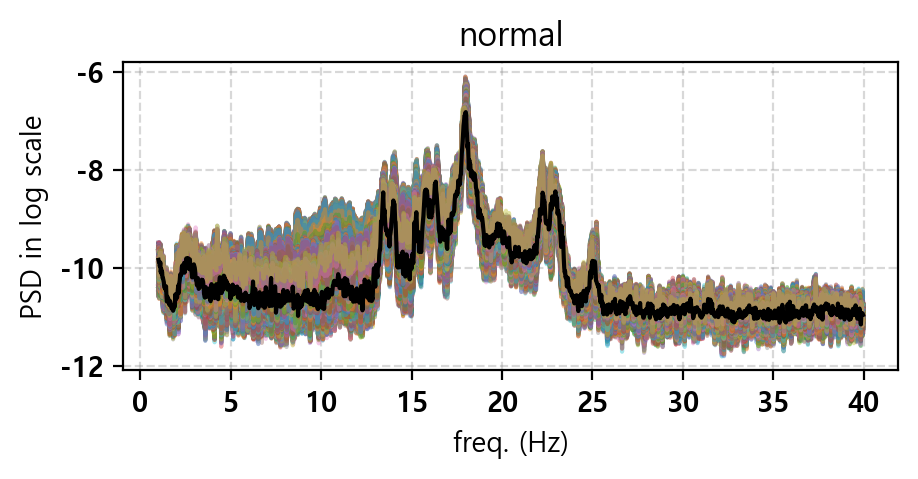

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[drift] PSD.shape = (1597, 112)


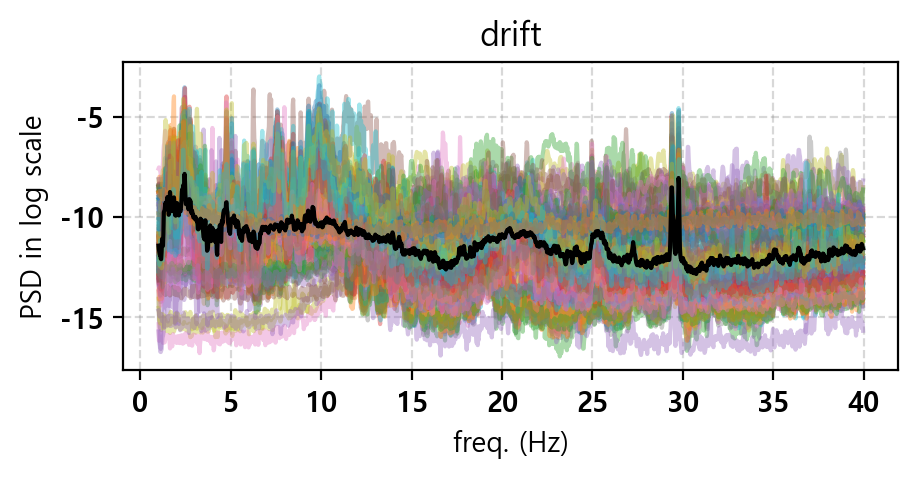

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[minor] PSD.shape = (1597, 113)


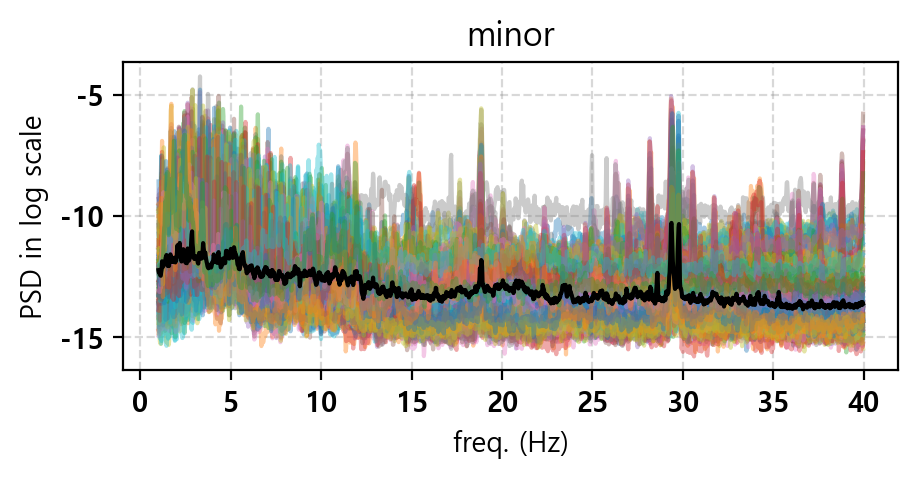

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[square] PSD.shape = (1597, 154)


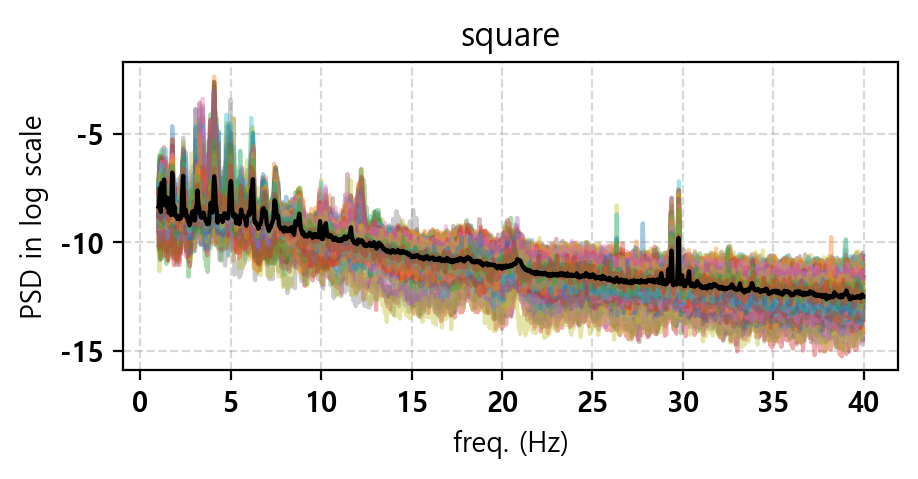

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[trend] PSD.shape = (1597, 164)


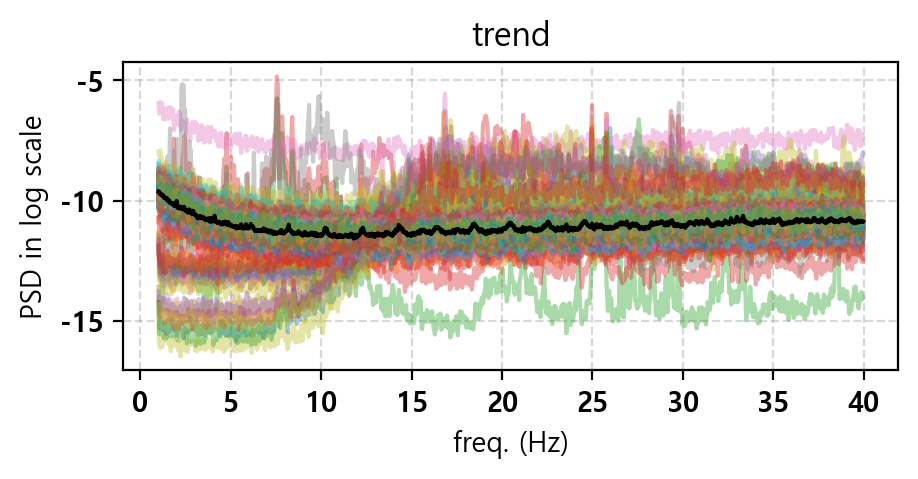

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[damage2] PSD.shape = (1597, 376)


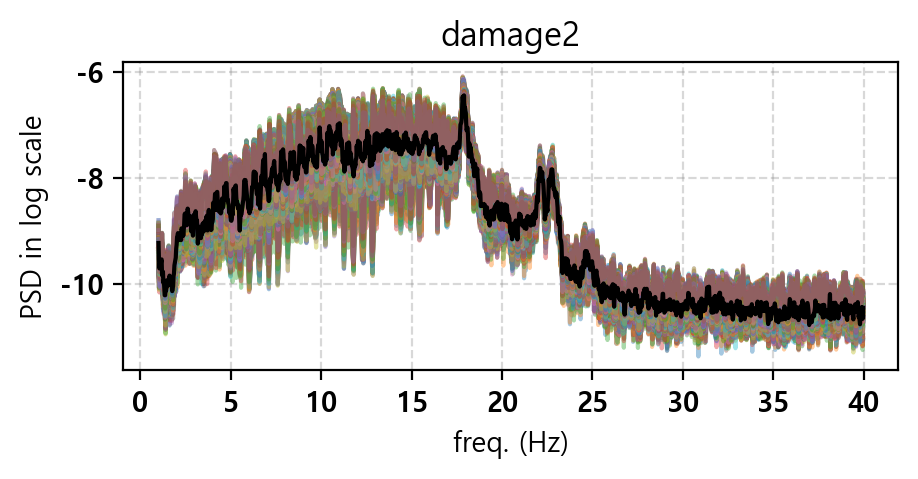

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Index: 41:1638
[damage4] PSD.shape = (1597, 253)


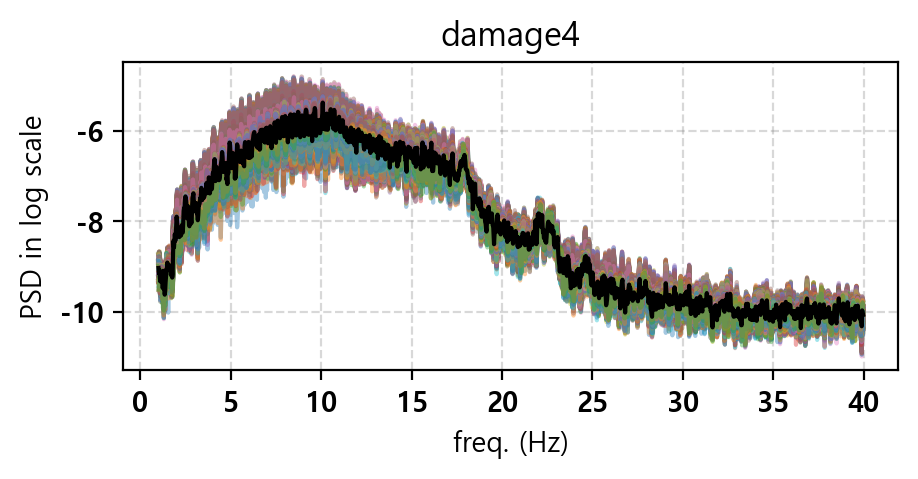

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [5]:
min_freq, max_freq = 1.0, 40.0
df_train_type_ratio['Total count'] = 0

for fn_type in fn_types:
    # Extract freq. & PSD in log-scale
    df = extract_raw_data(fn_path_dict, fn_type)

    # Find region of interest
    ind_min = np.argmin(abs(df.index.values - min_freq))
    ind_max = np.argmin(abs(df.index.values - max_freq))
    
    print(f'Index: {ind_min}:{ind_max}')

    if fn_type in df_train_type_ratio.index:
        if df_train_type_ratio.loc[fn_type, 'N_data']>df.shape[1]:
            df_train_type_ratio.loc[fn_type, 'Total count'] = df_train_type_ratio.loc[fn_type, 'N_data']
        else:
            df_train_type_ratio.loc[fn_type, 'Total count'] = df.shape[1]

    # Get data according to regions of interest
    df = df.iloc[ind_min:ind_max, :]
    print(f'[{fn_type}] PSD.shape = {df.shape}')
    
    if 1:
        plot_PSD(df, fn_type)

    print('%%%%%%%%' * 5)
    data_dict[fn_type] = df

# Adjust the difference of 3th decimal places by replacing freq. of 'normal' dataset
freq = data_dict['normal'].index
for key, value in data_dict.items():
    data_dict[key].index = freq

In [6]:
# Display setup for training set
display(df_train_type_ratio)
df_train_type_ratio.sum(axis = 0)

,Ratio,N_data,Total count
normal,0.6,540,659
drift,0.1,90,112
minor,0.1,90,113
square,0.1,90,154
trend,0.1,90,164


Ratio             1.0
N_data          900.0
Total count    1202.0
dtype: float64

In [7]:
df_train_set_list, df_train_labels_list = [], []
df_valid_set_list, df_valid_labels_list = [], []

dict_map = {
    'normal': 0, 'drift': 1, 'minor': 2, 'square': 3,
    'trend':4, 'damage2':5, 'damage4':6
    }

# Define all set of training data by random sampling
for i_seed in range(N_rep):
    # Set difference initial seed for random sampling
    np.random.seed(i_seed * 100 + i_seed * 10 + i_seed)

    df_trainset, df_validset = pd.DataFrame(), pd.DataFrame()
    for index_ in df_train_type_ratio.index:
        # Get Dataframe from dictionary
        df = data_dict[index_]
        # Get # samples for training set
        n_df_total = df_train_type_ratio.loc[index_, 'N_data']

        # Get Indice for training set
        ind_train_choice = np.random.choice(np.arange(df.shape[1]), n_df_total, replace = False)        
        # Get Indice for validation set
        ind_valid_choice = np.setdiff1d(np.arange(df.shape[1]), ind_train_choice) 
        
        # Concat. to "df_trainset"
        if df_trainset.shape[0] == 0: # This means "df is empty"
            df_trainset = df.iloc[:, ind_train_choice]
            df_validset = df.iloc[:, ind_valid_choice]
        else:
            df_trainset = pd.concat([df_trainset, df.iloc[:, ind_train_choice]], axis = 1)
            df_validset = pd.concat([df_validset, df.iloc[:, ind_valid_choice]], axis = 1)

    # Permutate index of training set
    ind_train_choice = np.random.permutation(df_trainset.shape[1])
    df_trainset = df_trainset.iloc[:, ind_train_choice]

    # Permutate index of validation set
    ind_valid_choice = np.random.permutation(df_validset.shape[1])
    df_validset = df_validset.iloc[:, ind_valid_choice]    

    # Append dataset randomly drawn and permulated
    df_train_set_list.append(df_trainset) # Training set
    df_train_labels_list.append(df_trainset.columns.map(dict_map)) # Using map function according to "dict_map"

    df_valid_set_list.append(df_validset) # Validation set
    df_valid_labels_list.append(df_validset.columns.map(dict_map)) # Using map function according to "dict_map"

    # Set Test dataset for 'damage states'
    df_test_set = pd.concat([data_dict['damage2'], data_dict['damage4']], axis = 1)
    df_test_labels = df_test_set.columns.map(dict_map)

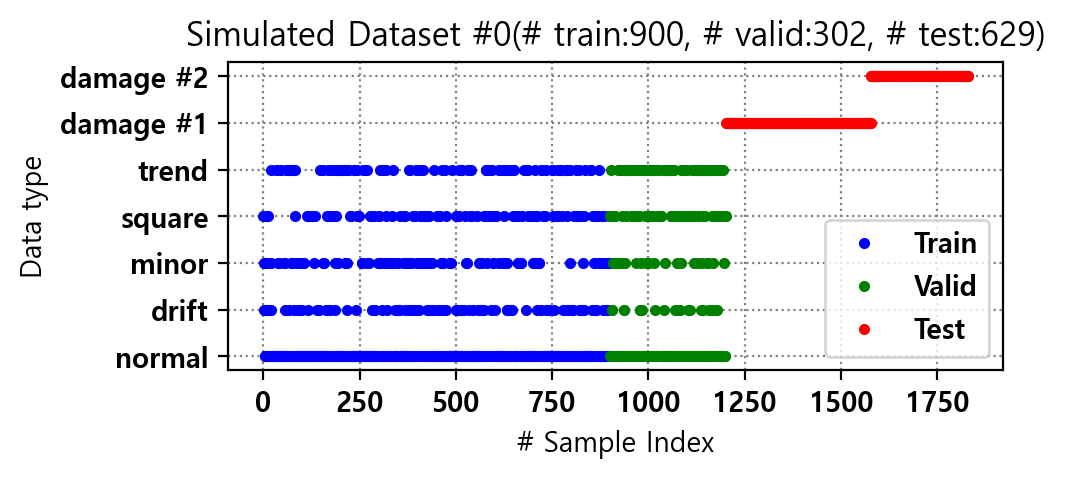

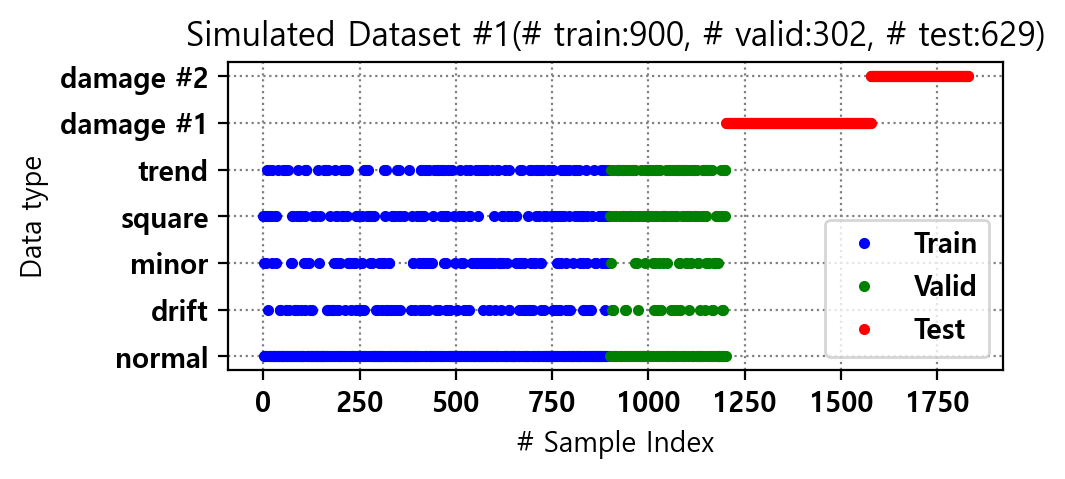

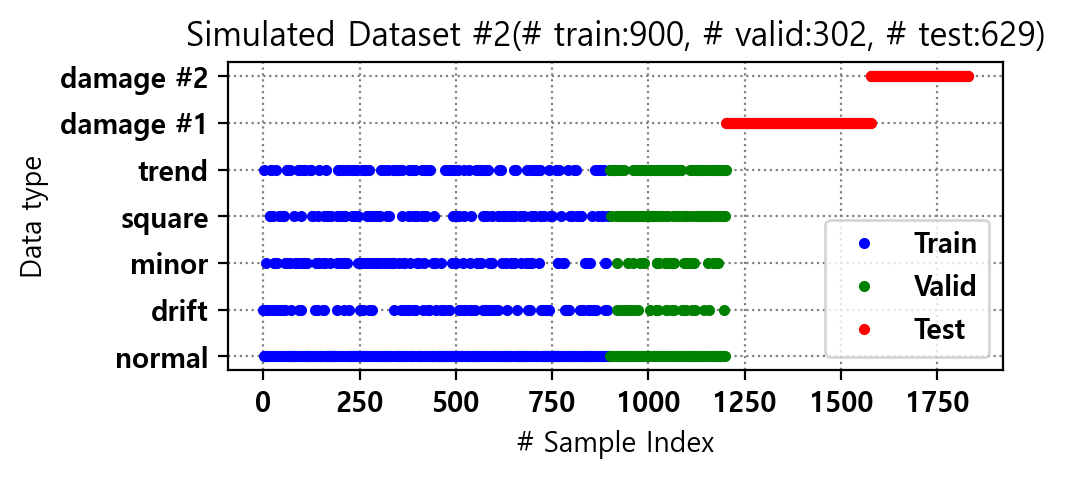

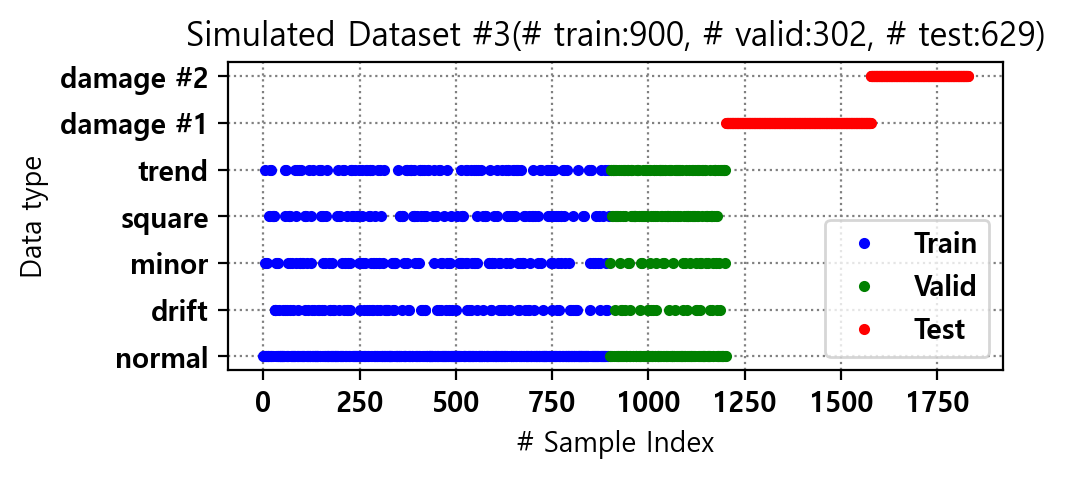

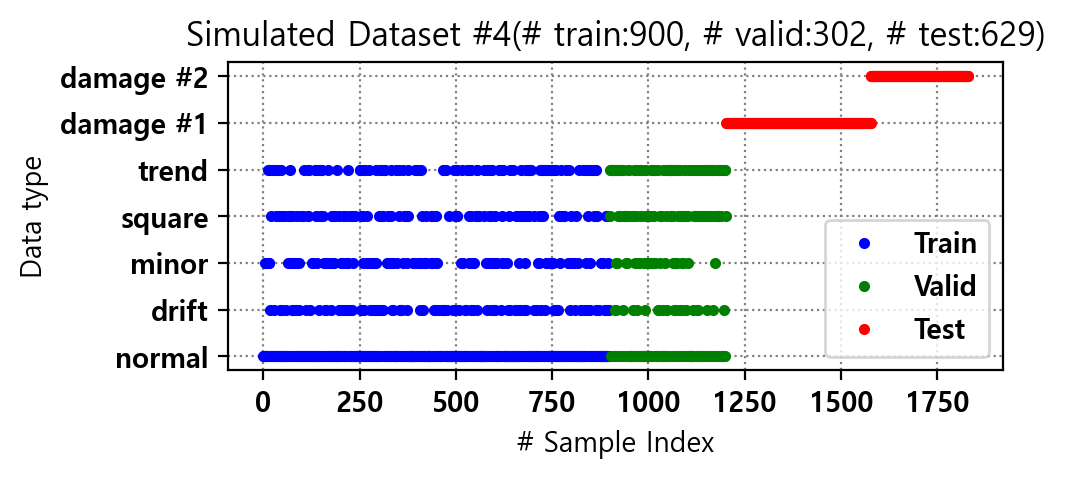

In [8]:
testset = df_test_labels

for i in range(len(df_train_labels_list)):
    trainset = df_train_labels_list[i]
    vaildset = df_valid_labels_list[i]

    n1 = trainset.shape[0]
    n2 = trainset.shape[0] + vaildset.shape[0]
    n3 = trainset.shape[0] + vaildset.shape[0] + testset.shape[0]

    plt.plot(np.arange(n1), trainset.to_numpy(), linestyle = 'None', marker = '.', color = 'b', label = 'Train')
    plt.plot(np.arange(n1, n2), vaildset.to_numpy(), linestyle = 'None', marker = '.', color = 'g', label = 'Valid')
    plt.plot(np.arange(n2, n3), testset.to_numpy(), linestyle = 'None', marker = '.', color = 'r', label = 'Test')
    plt.xlabel('# Sample Index')
    plt.ylabel('Data type')
    plt.grid(ls = ':', color = 'gray')
    plt.gca().set_yticks(range(7))
    plt.gca().set_yticklabels(fn_types[0:-2] + ['damage #1', 'damage #2'])
    plt.title(f'Simulated Dataset #{i}(# train:{trainset.shape[0]}, # valid:{vaildset.shape[0]}, # test:{testset.shape[0]})')
    plt.legend()
    plt.show()

In [9]:
print('%%%%%%%%%%' + '  Train   ' + '%%%%%%%%%%%%%%')
print(f"N_data: {df_train_type_ratio.sum(axis = 0)['N_data']}")
print(f"Total count: {df_train_type_ratio.sum(axis = 0)['Total count']}")
print(f"Ratio: {df_train_type_ratio.sum(axis = 0)['N_data']/df_train_type_ratio.sum(axis = 0)['Total count']*100}")

print('%%%%%%%%%%' + '  Validation   ' + '%%%%%%%%%%%%%%')
print(f"N_data: {df_train_type_ratio.sum(axis = 0)['Total count'] - df_train_type_ratio.sum(axis = 0)['N_data']}")
print(f"Total count: {df_train_type_ratio.sum(axis = 0)['Total count']}")
print(f"Ratio: {100 - df_train_type_ratio.sum(axis = 0)['N_data']/df_train_type_ratio.sum(axis = 0)['Total count']*100}")

print('%%%%%%%%%%' + '  Test   ' + '%%%%%%%%%%%%%%')
print(f"N_data: {testset.shape[0]}")

%%%%%%%%%%  Train   %%%%%%%%%%%%%%
N_data: 900.0
Total count: 1202.0
Ratio: 74.87520798668885
%%%%%%%%%%  Validation   %%%%%%%%%%%%%%
N_data: 302.0
Total count: 1202.0
Ratio: 25.12479201331115
%%%%%%%%%%  Test   %%%%%%%%%%%%%%
N_data: 629


In [10]:
import pickle

# Define filename for save
fn_sv = f'N_train{N_train}'
print(fn_sv)

# Define dictionary for saving pickle
data_sv_option = {}
data_sv_option['N_train'] = N_train
data_sv_option['df_train_type_ratio'] = df_train_type_ratio
## Save pickle
with open(fn_sv + '_option.pkl', 'wb') as fw:
    pickle.dump(data_sv_option, fw)

# Define train-dictionary for saving pickle
data_sv_train = {}
data_sv_train['df_train_sets'] = df_train_set_list
data_sv_train['df_train_labels'] = df_train_labels_list
## Save pickle
with open(fn_sv + '_train.pkl', 'wb') as fw:
    pickle.dump(data_sv_train, fw)

# Define validation-dictionary for saving pickle
data_sv_valid = {}
data_sv_valid['df_valid_sets'] = df_valid_set_list
data_sv_valid['df_valid_labels'] = df_valid_labels_list
## Save pickle
with open(fn_sv + '_valid.pkl', 'wb') as fw:
    pickle.dump(data_sv_valid, fw)

# Define test-dictionary for saving pickle
data_sv_test = {}
data_sv_test['df_test_sets'] = df_test_set
data_sv_test['df_test_labels'] = df_test_labels
## Save pickle
with open(fn_sv + '_test.pkl', 'wb') as fw:
    pickle.dump(data_sv_test, fw)


N_train900


In [11]:
# import pickle
# N_train = 900

# fn_load = f'N_train{N_train}.pkl'
# # Load pickle
# with open(fn_load, 'rb') as f:
#     pickle.load(f)